In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install opendatasets

`{"username":"asifhassan2002","key":"76731034a9c102c77db516b6ff0cb2ac"}`

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation")

#{"username":"asifhassan2002","key":"asifhassan2002"}

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: asifhassan2002
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation


100%|██████████| 714M/714M [00:11<00:00, 67.2MB/s]


# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE

- Data source: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation
- Clickable link for the full list of startups in AI medical imagery: https://research.aimultiple.com/looking-for-better-medical-imaging-for-early-diagnostic-and-monitoring-contact-the-leading-vendors-here/

https://www.kaggle.com/code/saeedghamshadzai/image-segmentation-brain-tumor-u-net-cnn

# Dataset Structure:
The dataset comprises brain MR images and manual FLAIR abnormality segmentation masks for 110 patients. Each image is provided in '.tif' format with 3 channels, corresponding to pre-contrast, FLAIR, and post-contrast sequences. Missing sequences are replaced with FLAIR to maintain consistency. Masks are binary, single-channel images delineating FLAIR abnormalities. Some images may not exhibit any abnormalities, resulting in entirely black masks. This characteristic allows for the identification of images with negative diagnoses. Patient data and abnormality genomic clusters are available in data.csv, though unused in this project. Refer to the dataset page for more details.

# TASK #2: IMPORT LIBRARIES AND DATASETS

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import tensorflow as tf
from tensorflow.python.keras import Sequential
from skimage import io
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display
import os
from PIL import Image
import sklearn as skl

In [5]:
# Navigate to My Drive directory to the dataset
%cd /content/lgg-mri-segmentation/kaggle_3m

/content/lgg-mri-segmentation/kaggle_3m


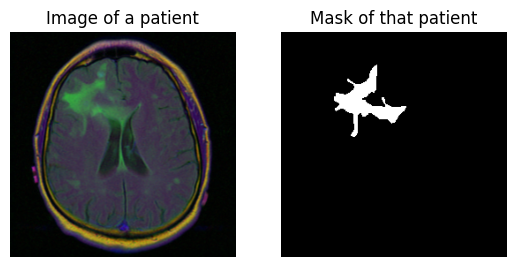

In [6]:
image = io.imread("TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif")
image_mask = io.imread('TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15_mask.tif')

plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
plt.title("Image of a patient")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(image_mask,cmap='gray')
plt.title("Mask of that patient")
plt.axis("off")

plt.show()

## Data Loading and Pre-processing

- The process begins by loading the paths of both the images and masks from **all folders** and organizing them into **one list**. This list is then passed to a function called` data_frame()` to create** train, validation, and test dataframes**. Within this function, the images (identified by paths not ending with '_mask') are selected and sorted based on the MRI number and patient IDs. Similarly, masks (identified by paths ending with '_mask') undergo the same sorting process. Additionally, the ID of each MRI is recorded. bold text

- Since some images may not exhibit any abnormalities, this information is extracted by checking if the mask contains any pixel values larger than 0.
- The outputs of this function are 3 dataframes containing IDs, images, masks, and diagnoses for each MRI.
- Several visualizations are conducted to aid in understanding the dataset. These include separate visualizations for positive MRIs and negative MRIs. Additionally, a visualization depicting the class distribution across train, test, and validation dataframes is generated to illustrate the proportion of positive and negative data within each dataset split.

In [6]:
# Path to the images and masks
IMAGE_PATH = '/content/lgg-mri-segmentation/kaggle_3m'

# Size of the images and masks
IMAGE_SIZE = (256, 256)


In [7]:
# A list to hold each image and mask's path
paths = []

for dirname in os.listdir(IMAGE_PATH):
    if os.path.isdir(os.path.join(IMAGE_PATH, dirname)):

        for filename in os.listdir(os.path.join(IMAGE_PATH, dirname)):
            # Only the files with ',tif' format should be added to the 'paths' list
            if filename.endswith('.tif'):
                paths.append(IMAGE_PATH+'/'+dirname+'/'+filename)


In [8]:
print (len(paths))

7858


In [9]:
paths[1:5]

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_1.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_2_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_9.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_7.tif']

### Making dataframes


In [10]:
# Making a dataframe from the list "paths" by separating Images and Masks, extracting IDs, and diagnoses.

def data_frame(data):
    # Storing only paths that don't end with 'mask.tif'
    images = list(filter(lambda x: not x.endswith('mask.tif'), data))
    # Sorting images based on the number of each MRI.
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-1][:-4]))
    # Sorting by the patient IDs (each patient has more than 1 MRIs)
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))

    # Storing the image IDs
    IDs = list (map(lambda x: x.rsplit('/',2)[-2],images))

    # Storing only paths that end with 'mask.tiff'
    masks = list(filter(lambda x: x.endswith('mask.tif'), data))
    # Sorting masks based on the number of each MRI.
    masks.sort(key = lambda x: int (x.rsplit('_',3)[-2]))
    # Sorting by the patient IDs (each patient has more than 1 MRIs)
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-3]))

    # Opens the images
    pixels = lambda x: Image.open(x)
    # Selects the largest pixel
    largest_pixel = lambda y: np.max(pixels(y))
    # Determines if the mask contains an abnormality or not (+ or -)
    # Remember that a negative image's mask is just an entirely black image.
    diagnotic_function = lambda z: 1 if largest_pixel(z) > 0 else 0
    # Storing the diagnosis corresponding to each image
    diagnoses = list (map(lambda x: diagnotic_function(x),masks))

    # Making the dataframe
    DataFrame = pd.DataFrame({'patient_id': IDs, 'image_path': images, 'mask_path': masks, 'Diagnosis': diagnoses})

    return DataFrame

In [11]:
# Making the dataframes
brain_df = data_frame(paths)

In [12]:
# save the brain_df file
%cd /content
brain_df.to_csv('brain_df.csv', index=False)

/content


In [19]:
brain_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classification/brain_df.csv', index=False)

In [13]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   Diagnosis   3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [14]:
brain_df.head()

patient_id                                         image_path  \
0  TCGA_DU_6399_19830416  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1  TCGA_DU_6399_19830416  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2  TCGA_DU_6399_19830416  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3  TCGA_DU_6399_19830416  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4  TCGA_DU_6399_19830416  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                           mask_path  Diagnosis  
0  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  
1  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  
2  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  
3  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  
4  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0

In [15]:
brain_df.Diagnosis.value_counts()

Diagnosis
0    2556
1    1373
Name: count, dtype: int64

# TASK #3: PERFORM DATA VISUALIZATION

In [ ]:
def plot_images_and_masks (images, masks):

    num_samples = len(images)
    num_rows = 2

    # Define subplots
    fig, axes = plt.subplots(ncols= num_samples,
                             nrows= num_rows,
                             figsize=(num_samples*5, num_samples+(num_rows*2)),
                             dpi=200)

    for i in range(num_samples):
      # Plotting image
        axes[0, i].imshow(Image.open(images[i]), cmap='gray')
        axes[0, i].set_title('Image', fontsize=20 )
        axes[0, i].axis('off')

        # Plotting mask
        axes[1, i].imshow(Image.open(masks[i]), cmap='gray')
        axes[1, i].set_title('Mask', fontsize=20)
        axes[1, i].axis('off')

    # Adding title
    plt.suptitle('Images and Masks', fontsize=30)

Positive Images and Masks

In [ ]:
plot_images_and_masks(brain_df[brain_df['Diagnosis'] == 1]['image_path'].values[:6],
                      brain_df[brain_df['Diagnosis'] == 1]['mask_path'].values[:6])

Output hidden; open in https://colab.research.google.com to view.

 Negative Images and Masks

In [ ]:
plot_images_and_masks(brain_df[brain_df['Diagnosis'] == 0]['image_path'].values[:6],
                      brain_df[brain_df['Diagnosis'] == 0]['mask_path'].values[:6])

Output hidden; open in https://colab.research.google.com to view.

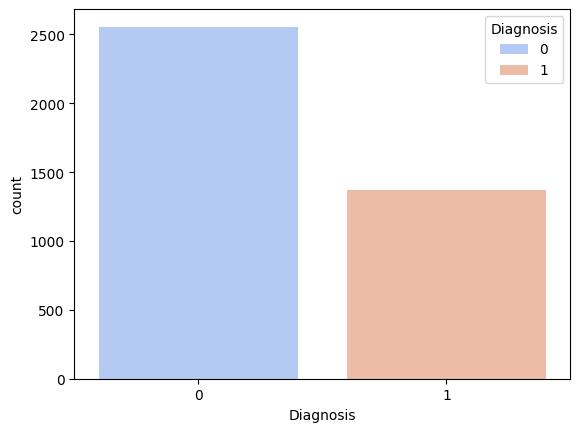

In [ ]:
sns.countplot(data=brain_df, x='Diagnosis',hue='Diagnosis', palette='coolwarm')
plt.show()

Ploting 6 randomly selected (1) MRI scan images from only sick patients followed by (2) corresponding mask, (3) both MRI image and the corresponding mask (in red color) on top of each other

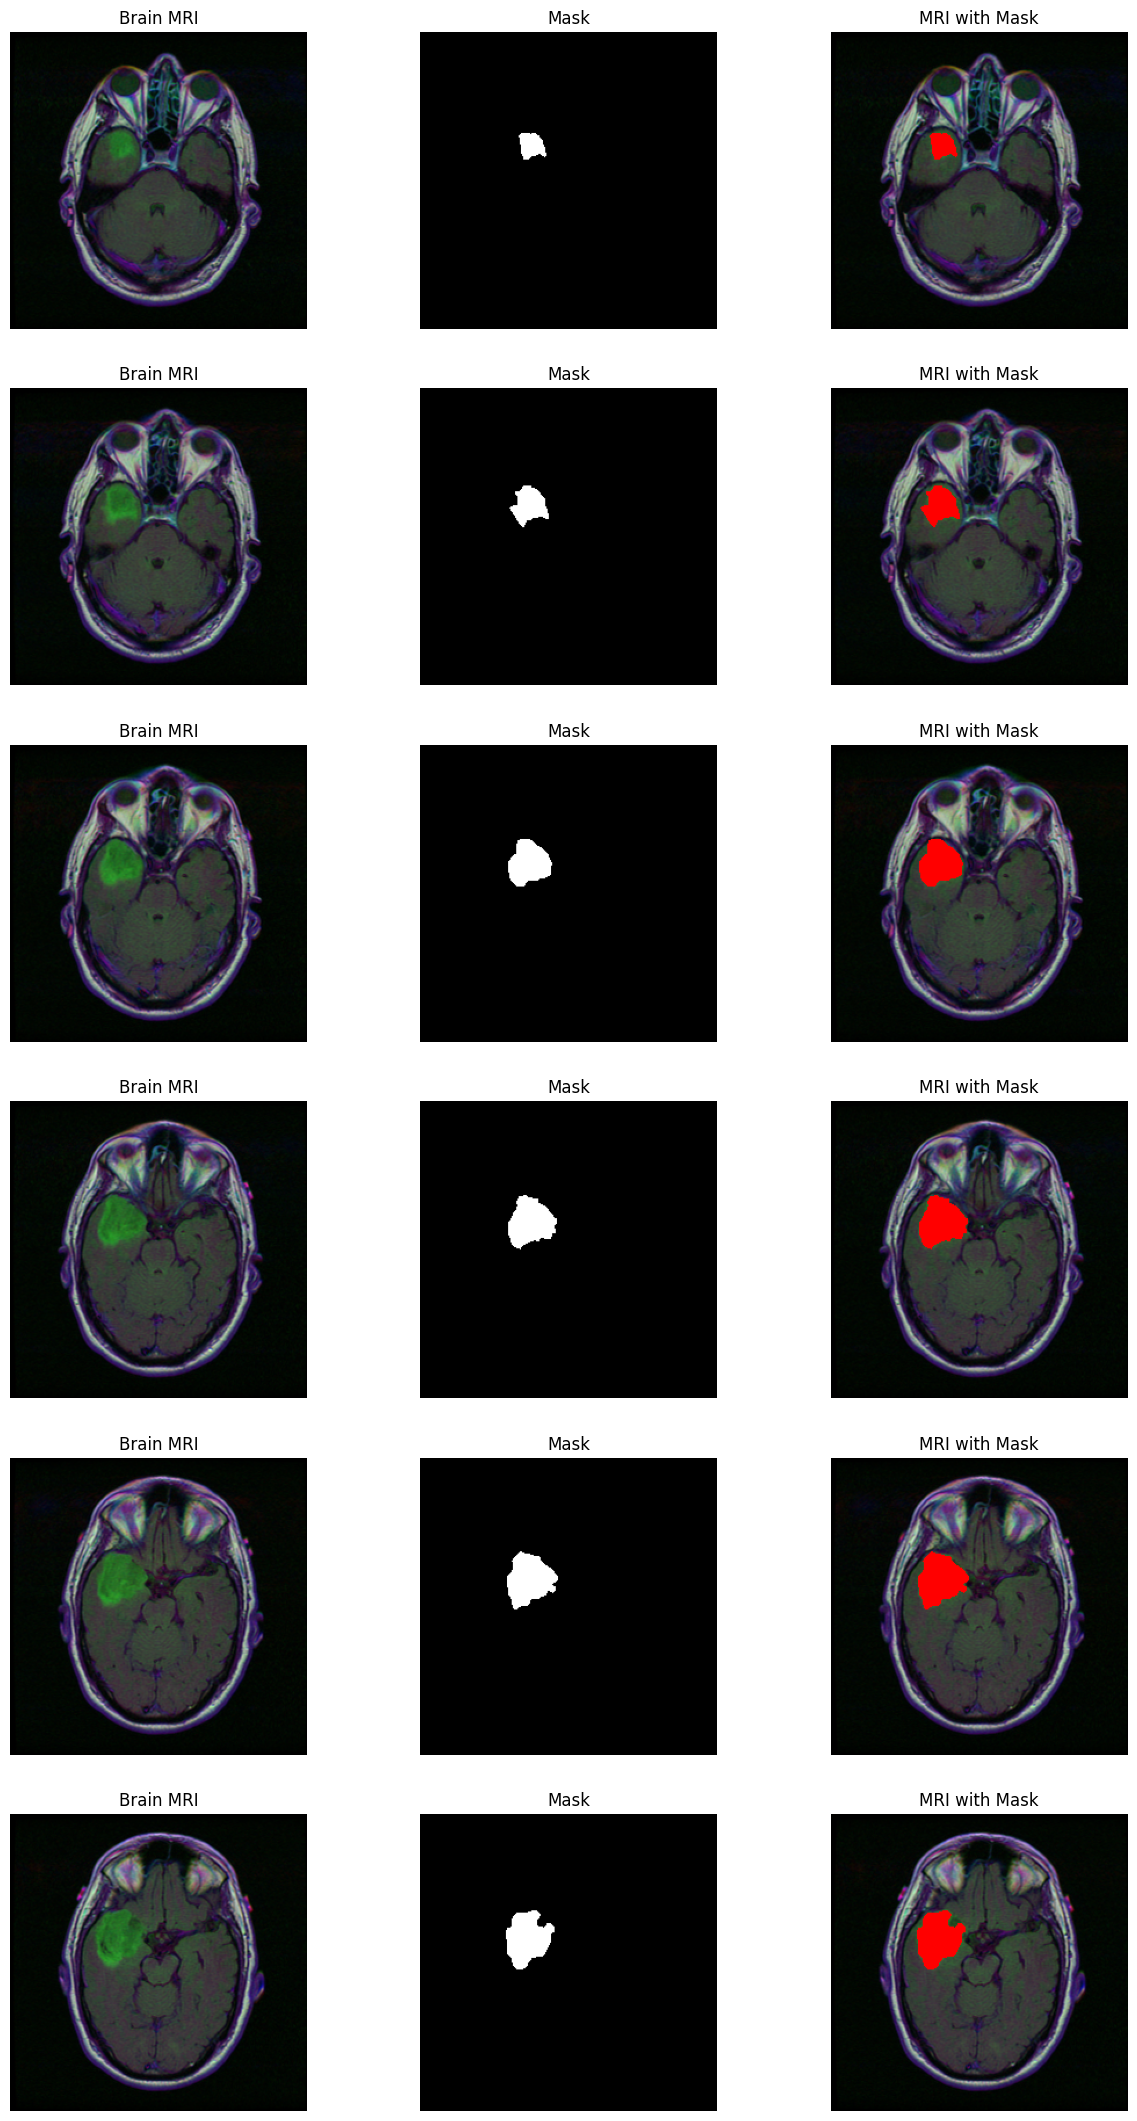

In [ ]:
# Advanced Visualization: visualize the MRI scans along with their mask on one image
count = 0
fig, axs = plt.subplots(6,3, figsize=(15,27))
for i in range(len(brain_df)):
  if brain_df['Diagnosis'][i] == 1 and count < 6:
  # read the images
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)
    axs[count][0].axis('off')

    # obtain the mask for the image
    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')
    axs[count][1].axis('off')

    # replace the values in the image with red color (255,0,0) if any mask pixel in the mask was = 255
    img[mask == 255] = (255,0,0)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    axs[count][2].axis('off')

    count += 1

plt.show()

# TASK #4: UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS AND RESNETS

- Feature Extraction and Convolutions: https://setosa.io/ev/image-kernels/
- CNN Visualization: https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html


- Link to ResNet paper entitled (Deep Residual Learning for Image Recognition): https://arxiv.org/pdf/1512.03385.pdf

# TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND TRANSFER LEARNING

- Excellent Resource on transfer learning by Dipanjan Sarkar: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
- Article by Jason Brownlee: https://machinelearningmastery.com/transfer-learning-for-deep-learning/

# TASK #6: TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT

In [16]:
brain_df_train = brain_df.drop('patient_id', axis=1)
brain_df_train.shape

(3929, 3)

In [17]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.

brain_df_train.Diagnosis = brain_df_train.Diagnosis.apply(lambda x: str(x))

In [28]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   Diagnosis   3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [18]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(brain_df_train, test_size=0.15)

In [ ]:
train_df.shape, test_df.shape

((3339, 3), (590, 3))

In [19]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [21]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

Img_data_Gen = ImageDataGenerator( rescale= 1./255 , validation_split=0.15)

# This class generates batches of tensor image data with real-time data augmentation.


In [159]:
train_generator = Img_data_Gen.flow_from_dataframe(
    dataframe = train_df,
    directory= '/', # Base directory where the images are stored. Paths in `image_path` are relative to this directory.
    x_col= 'image_path',
    y_col= 'Diagnosis',
    subset= 'training',
    batch_size= 16,
    shuffle= True,
    class_mode= 'categorical',
    target_size= (256, 256)
)

valid_generator = Img_data_Gen.flow_from_dataframe(
    dataframe = train_df,
    directory= '/',
    x_col= 'image_path',
    y_col= 'Diagnosis',
    subset= 'validation',
    batch_size= 16,
    shuffle= True,
    class_mode= 'categorical',
    target_size= (256, 256)
)

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory= '/',
    x_col= 'image_path',
    y_col= 'Diagnosis',
    #batch_size= 16,
    shuffle= False,
    class_mode= 'categorical',
    target_size= (256, 256)
)

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [160]:
# Get the ResNet50 base model
basemodel = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top = False,
    input_tensor = tf.keras.Input(shape=(256,256,3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [161]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [162]:
# Freeze the base model layers to retain pre-trained features

for layer in basemodel.layers:
  layer.trainble = False

  # Freezes the layer weights so they will not be updated during training.
  # The model will use the pre-trained weights as they are and not modify them based on your dataset.
  # This is common in transfer learning, where we want to leverage pre-trained models without retraining the base model layers.

In [163]:
# Add custom layers on top of the base model

headmodel = basemodel.output
headmodel = tf.keras.layers.AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = tf.keras.layers.Flatten(name='flatten')(headmodel)
headmodel = tf.keras.layers.Dense(256, activation='relu')(headmodel)
headmodel = tf.keras.layers.Dropout(0.3)(headmodel)
headmodel = tf.keras.layers.Dense(256, activation='relu')(headmodel)
headmodel = tf.keras.layers.Dropout(0.3)(headmodel)
headmodel = tf.keras.layers.Dense(256, activation='relu')(headmodel)
headmodel = tf.keras.layers.Dropout(0.3)(headmodel)
headmodel = tf.keras.layers.Dense(2, activation='softmax')(headmodel)
model = tf.keras.models.Model(inputs=basemodel.input, outputs=headmodel)

# `inputs=basemodel.input`: Takes the original input from the base model.
# `outputs=headmodel`: Outputs predictions from the custom head added on top.


In [164]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,817,218 (98.48 MB)

 Trainable params: 25,764,098 (98.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# compile the model

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Early stopping: Stop training if validation loss doesn't improve after a certain number of epochs
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=20
)

# Model checkpoint: Save the best model with the least validation loss
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='classifier-resnet-weights.keras',
    verbose=1,
    save_best_only=True


In [ ]:
%cd /content

/content


In [ ]:
# Fit the model using data generators
history = model.fit(
    train_generator,              # Training data generator
    # steps_per_epoch=train_generator.n // 16,  # Number of steps per epoch (total samples divided by batch size)
    epochs=60,                      # Number of epochs
    # validation_data=valid_generator,  # Validation data generator
    # validation_steps=valid_generator.n // 16,  # Validation steps (total samples divided by batch size)
    callbacks=[checkpointer, earlystopping]  # Callbacks (model checkpoint and early stopping)
)


In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Save the model's weights
# model.save_weights('classifier-resnet-weights.weights.h5')


In [ ]:
!cp classifier-resnet-weights.weights.h5 /content/drive/MyDrive/Colab\ Notebooks/Brain\ Tumor\ Classification

In [ ]:
# save the model architecture to json file for future use
model_json = model.to_json()
with open("classifier-resnet-model.json", 'w') as json_file:
  json_file.write(model_json)

In [ ]:
!cp /content/classifier-resnet-model.json /content/drive/MyDrive/Colab\ Notebooks/Brain\ Tumor\ Classification

# TASK #7: ASSESS TRAINED MODEL PERFORMANCE

In [26]:
%cd /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classification

/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classification


In [24]:
brain_df = pd.read_csv('brain_df.csv')

In [28]:
# Load pretrained model (instead of training the model for 1+ hours)
with open ('classifier-resnet-model.json','r') as json_file:
  json_savedModel =json_file.read()

In [29]:
# load the model
my_pretrained_model = tf.keras.models.model_from_json(json_savedModel)
my_pretrained_model.load_weights('kaggle-96.8%-resnet-weights.weights.h5')
my_pretrained_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [46]:
# make prediction

test_predict = my_pretrained_model.predict(test_generator, steps= test_generator.n // 16)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [47]:
test_predict.shape

(590, 2)

In [48]:
test_predict

array([[9.9997407e-01, 2.5913430e-05],
       [1.4024475e-06, 9.9999851e-01],
       [9.9999768e-01, 2.3042874e-06],
       ...,
       [1.0000000e+00, 6.1364145e-09],
       [5.0413480e-12, 1.0000000e+00],
       [9.9959475e-01, 4.0523062e-04]], dtype=float32)

In [50]:
%cd /content

/content


In [68]:
# Get predicted class labels (0 or 1)
predicted_labels = np.argmax(test_predict, axis=1)

# Create the DataFrame
test_predict_df = pd.DataFrame({
    'image_path': test_df['image_path'],
    'mask_path': test_df['mask_path'],
    'Diagnosis': test_df['Diagnosis'].astype(int), # Convert back to integer
    'prediction_diagnosis': predicted_labels
})

# Display the DataFrame (optional)
print(test_predict_df.head())

# Save the DataFrame to a CSV file (optional)
test_predict_df.to_csv('test_predictions.csv', index=False)

                                             image_path  \
3569  /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
1681  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
1897  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
1863  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
1502  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   

                                              mask_path  Diagnosis  \
3569  /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...          0   
1681  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          1   
1897  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          0   
1863  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          0   
1502  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          1   

      prediction_diagnosis  
3569                     0  
1681                     1  
1897                     0  
1863                     0  
1502                     1  


In [78]:
test_predict_df.head()

image_path  \
3569  /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
1681  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
1897  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
1863  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
1502  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   

                                              mask_path  Diagnosis  \
3569  /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...          0   
1681  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          1   
1897  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          0   
1863  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          0   
1502  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          1   

      prediction_diagnosis  
3569                     0  
1681                     1  
1897                     0  
1863                     0  
1502                     1

In [52]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [53]:
predict

array(['0', '1', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0',
       '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '1',
       '0', '1', '0', '0', '0', '1', '1', '1', '0', '1', '1', '0', '0',
       '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0',
       '1', '1', '0', '1', '1', '0', '1', '0', '0', '0', '0', '1', '0',
       '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1', '1', '0',
       '1', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1',
       '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0',
       '0', '0', '1', '0', '1', '1', '1', '1', '1', '0', '0', '0', '0',
       '0', '0', '1', '1', '0', '0', '0', '1', '1', '0', '1', '1', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1',
       '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0

In [54]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test_df['Diagnosis'])[:len(predict)]
len(original)

590

In [55]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9847457627118644

Confusion Matrix:
[[377   5]
 [  4 204]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       382
           1       0.98      0.98      0.98       208

   micro avg       0.98      0.98      0.98       590
   macro avg       0.98      0.98      0.98       590
weighted avg       0.98      0.98      0.98       590



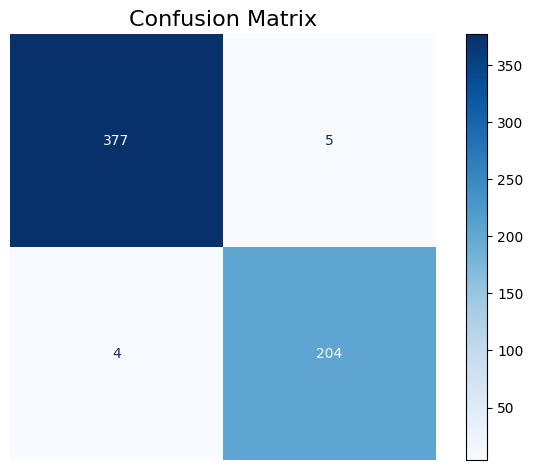

In [157]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

cm = confusion_matrix(original,predict)

print("Confusion Matrix:")
print(cm)

report = classification_report(original, predict, labels = [0,1])
print(report)

# Create a heatmap of the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(original))
cm_display.plot(cmap='Blues', values_format='d', ax=plt.gca(), colorbar=True)

# Adding labels and title
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.axis(False)

# Show the plot
plt.tight_layout()
plt.show()

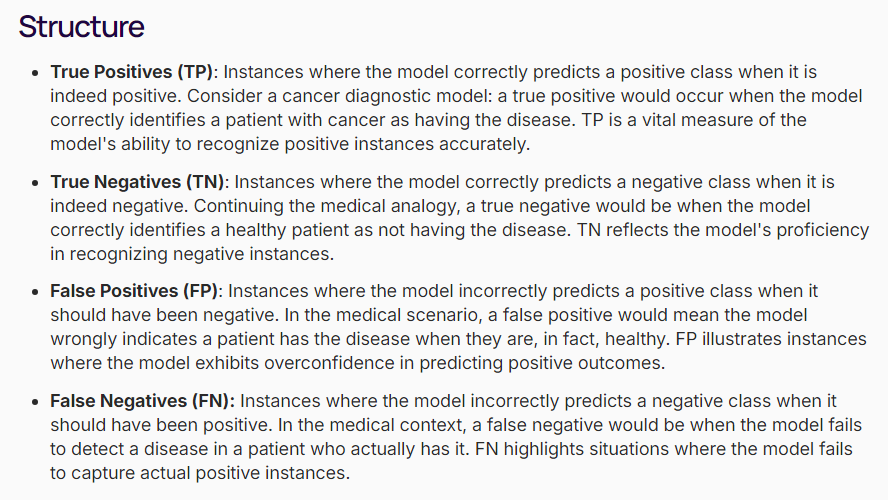

edfa849b-03fb-43d2-aba5-1f53a8884e6f_image5.avif

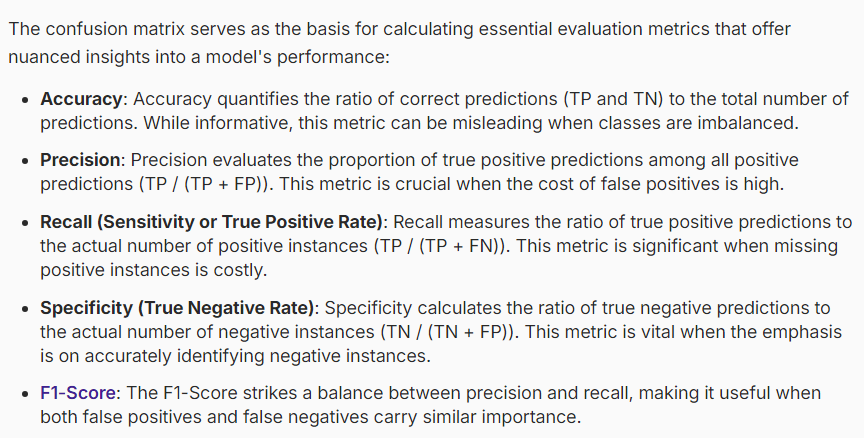

https://encord.com/glossary/confusion-matrix/

# TASK #8: UNDERSTAND THE THEORY AND INTUITION BEHIND RESUNET MODELS

# U-Net Model Overview:
The U-Net model is a CNN architecture specifically tailored for biomedical image segmentation tasks, such as identifying abnormalities in brain MRI scans. Its distinctive encoder-decoder structure enables efficient mapping of three-channel MRI images to one-channel segmentation masks. The encoder extracts features from the input images, while the decoder reconstructs the masks, effectively highlighting areas of abnormality. This architecture preserves spatial information and detail, making it well-suited for accurate segmentation in this project.

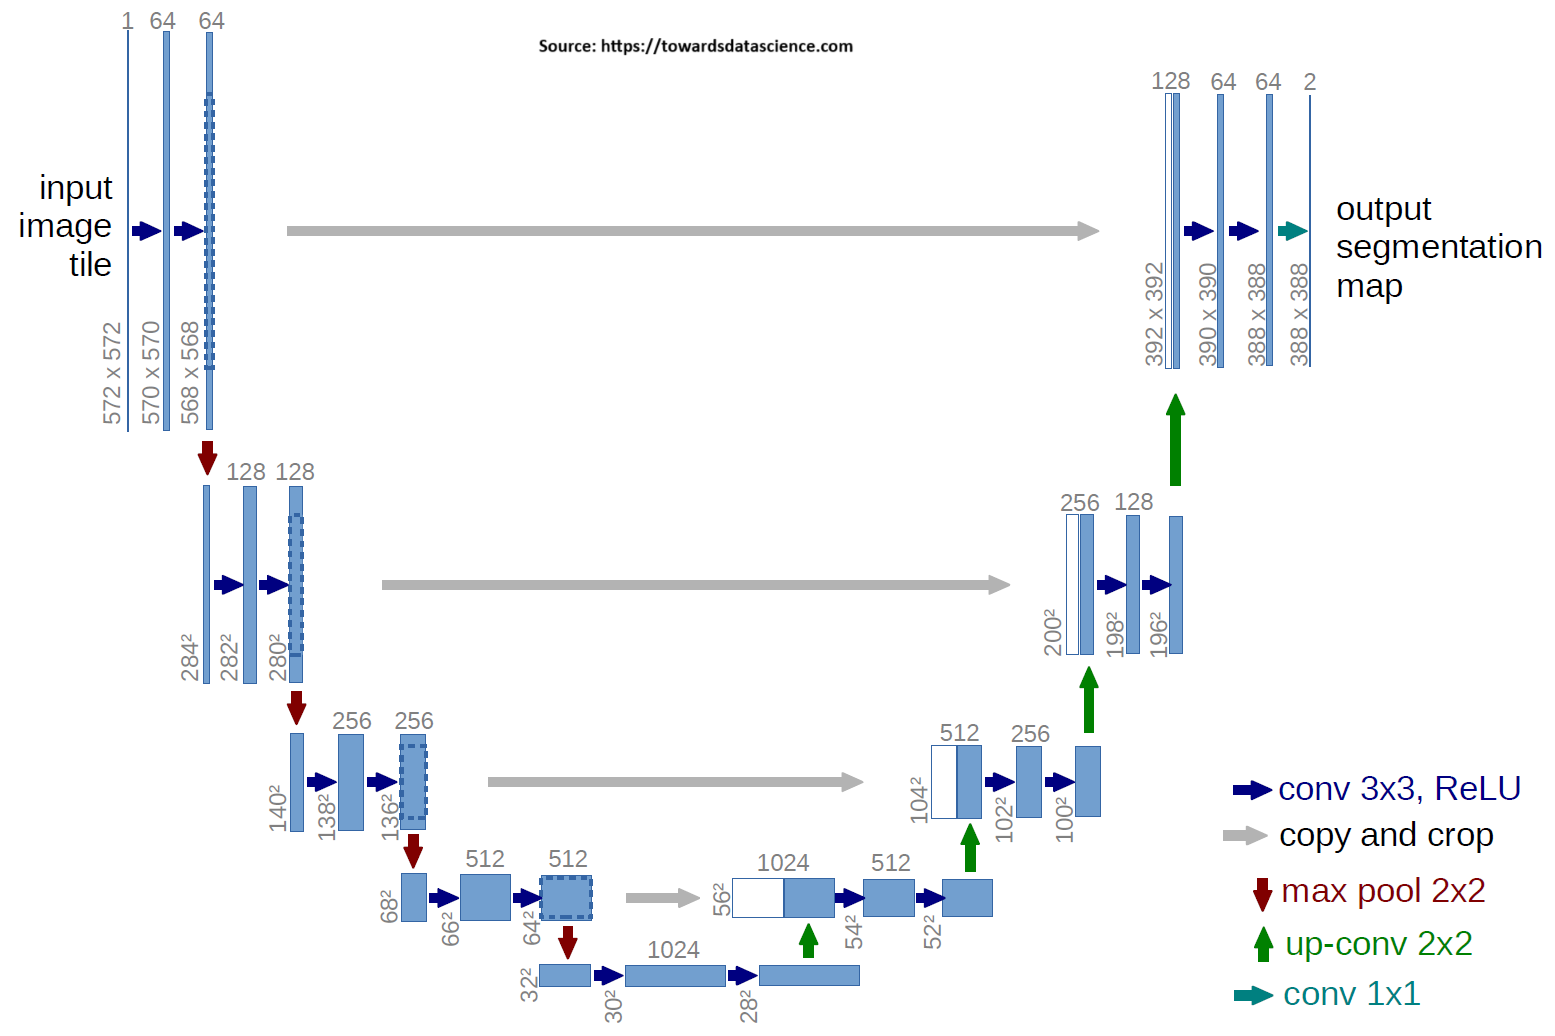

## RESUNET ADDITIONAL RESOURCES:
Paper #1: https://arxiv.org/abs/1505.04597

Paper #2: https://arxiv.org/abs/1904.00592

Great article: https://towardsdatascience.com/introduction-to-u-net-and-res-net-for-image-segmentation-9afcb432ee2f

# TASK #9: BUILD A SEGMENTATION MODEL TO LOCALIZE TUMOR

## Config

In [83]:
imagePath_df = pd.DataFrame()
imagePath_df['image-path'] = brain_df['image_path']
imagePath_df['mask-path'] = brain_df['mask_path']

In [84]:
imagePath_df.head()

image-path  \
0  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                           mask-path  
0  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...  
1  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...  
2  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...  
3  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...  
4  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...

In [91]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(imagePath_df, test_size= 0.15)

In [93]:
train.shape , test.shape

((3339, 2), (590, 2))

In [115]:
EPOCHS = 60
BATCH_SIZE = 32
ImgHieght = 256
ImgWidth = 256
Channels = 3

## Data Generator

In [94]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

## Train

In [96]:
# image generator
from keras_preprocessing.image import ImageDataGenerator

imagegen =ImageDataGenerator(rescale = 1./255,
                             **data_augmentation)
maskgen = ImageDataGenerator(rescale= 1./255,
                             **data_augmentation)

# train generator
timage_generator = imagegen.flow_from_dataframe(
    dataframe = train,
    x_col = 'image-path',
    batch_size= BATCH_SIZE,
    seed = 42,
    class_mode = None,
    target_size = (ImgHieght, ImgWidth),
    color_mode='rgb'
)

# validation data generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')



Found 3339 validated image filenames.
Found 3339 validated image filenames.


## Validation

In [97]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)


# train generator
vimage_generator=imagegen.flow_from_dataframe(dataframe=test,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation data generator
vmask_generator=maskgen.flow_from_dataframe(dataframe=test,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')


Found 590 validated image filenames.
Found 590 validated image filenames.


In [98]:
def data_iterator(image_gen, mask_gen):
  for img , mask in zip(image_gen, mask_gen):
    yield img, mask

In [99]:
train_gen = data_iterator(timage_generator, tmask_generator)
valid_gen = data_iterator(vimage_generator, vmask_generator)

In [101]:
train_gen

<generator object data_iterator at 0x7c069871c7c0>

## UNet

In [103]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [104]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""

    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [105]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""

    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [107]:
input_img = Input((ImgHieght, ImgWidth, 3), name = 'img')

unet_model = get_unet(input_img,
                 n_filters= 16,
                 dropout=0.2,
                 batchnorm= True)

unet_model.compile (optimizer = Adam(),
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

In [ ]:
unet_model.summary()

## ***Training***

In [117]:
callbacks = [

    EarlyStopping(
        patience=10,
        verbose=1
    ),

    ReduceLROnPlateau(factor=0.1,
                       patience=5,
                       min_lr=1e-5,
                       verbose=1),

    ModelCheckpoint('unet_model-brain-mri.weights.h5',
                    verbose=1,
                    save_best_only=True,
                    save_weights_only=True)
]

In [122]:
STEP_SIZE_TRAIN = timage_generator.n// BATCH_SIZE
STEP_SIZE_VALID = vimage_generator.n// BATCH_SIZE

In [ ]:
results = unet_model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID)

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.grid(False)
plt.show()

## Prediction

In [123]:
%cd /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classification

/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classification


In [124]:
# load the best model
unet_model.load_weights('unet_model-brain-mri.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 66 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [125]:
eval_results = unet_model.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.9975 - loss: 0.0066


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


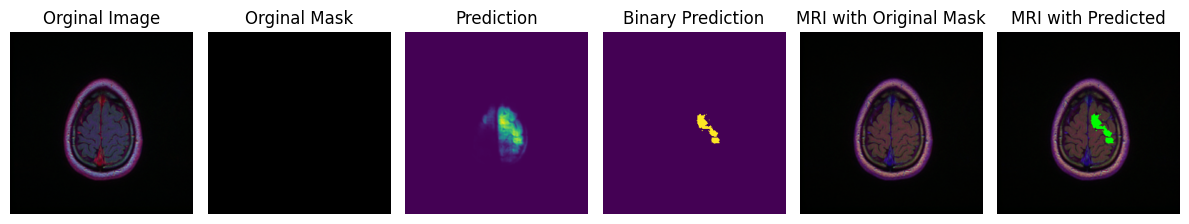

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


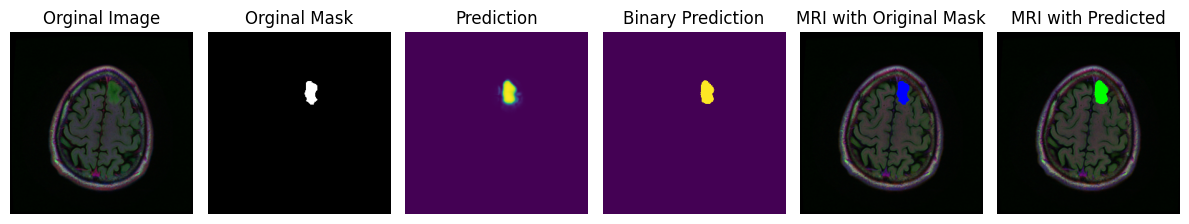

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


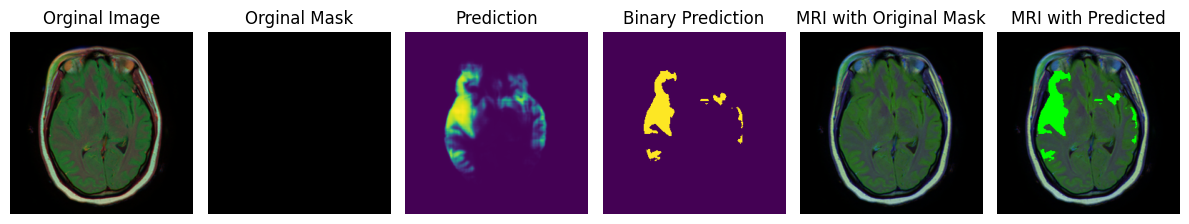

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


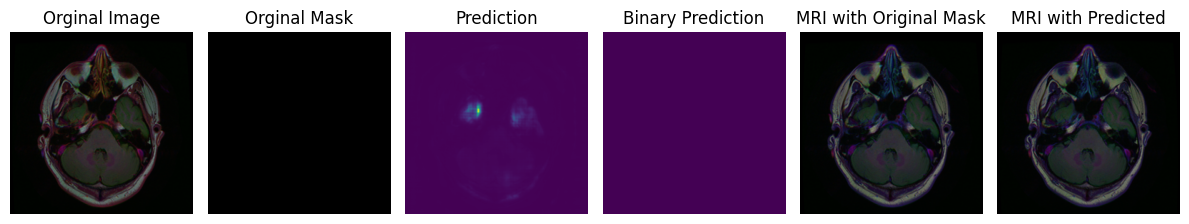

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


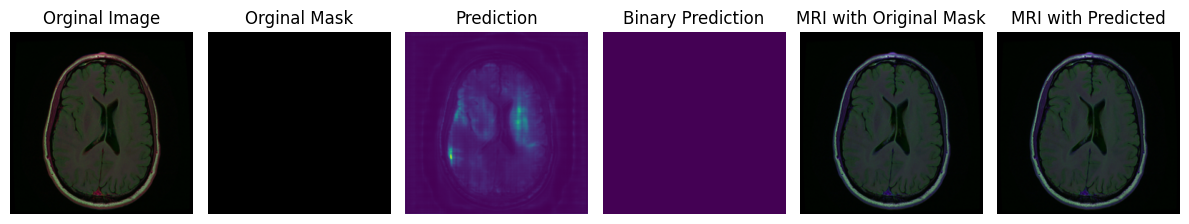

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


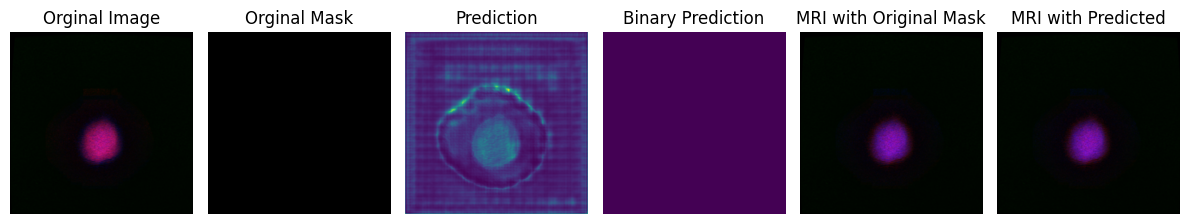

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


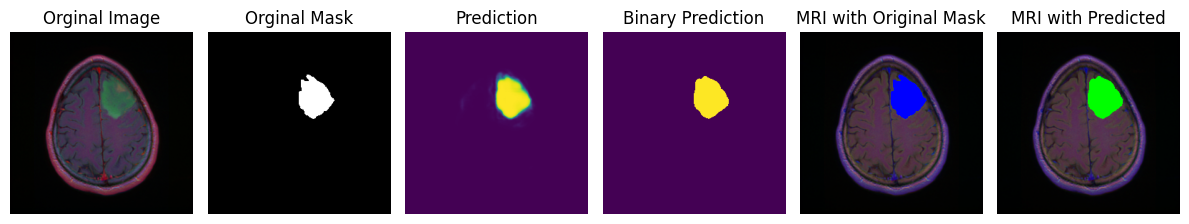

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


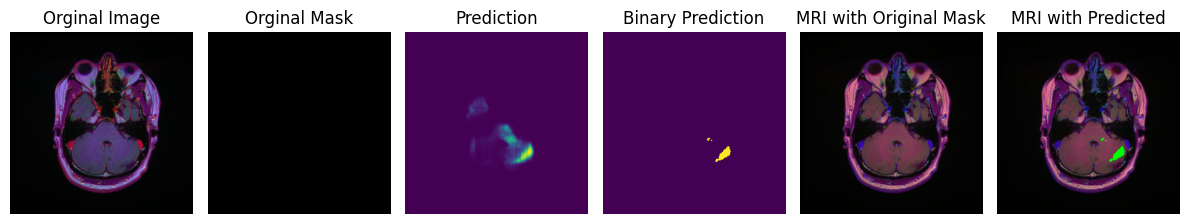

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


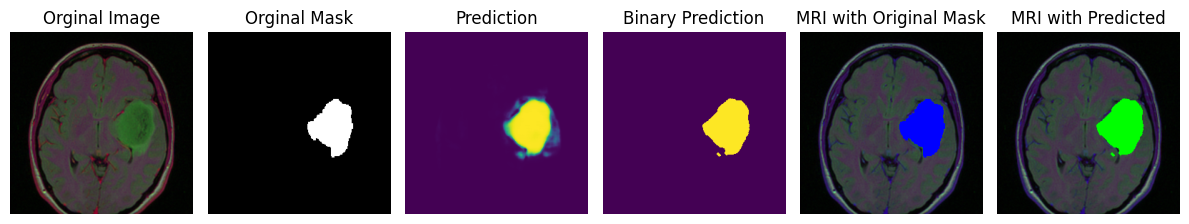

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


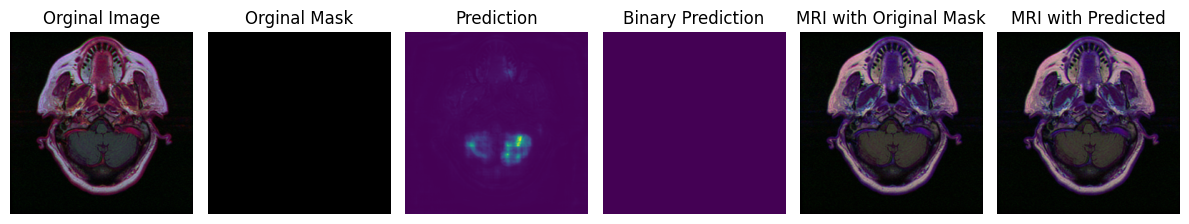

In [169]:
for i in range (10):
  idx = np.random.randint (0, len(imagePath_df))

  imagePath =imagePath_df['image-path'].iloc[idx]
  maskPath = imagePath_df['mask-path'].iloc[idx]

  image = cv2.imread(imagePath)
  mask = cv2.imread(maskPath)

  img = cv2.resize(image,(ImgHieght,ImgWidth))
  img = img / 255
  img = img[np.newaxis,: , :, :]
  pred = unet_model.predict(img)

  plt.figure (figsize=(12,12))

  plt.subplot(1,6,1)
  plt.imshow(np.squeeze(img))
  plt.title('Orginal Image')
  plt.axis('off')

  plt.subplot(1,6,2)
  plt.imshow(mask)
  plt.title('Orginal Mask')
  plt.axis('off')

  plt.subplot(1,6,3)
  plt.imshow(np.squeeze(pred))
  plt.title("Prediction")
  plt.axis('off')

  plt.subplot(1,6,4)
  plt.imshow(np.squeeze(pred)> 0.5)
  plt.title('Binary Prediction')
  plt.axis('off')

  plt.subplot(1, 6, 5)
  img_with_mask = image.copy()
  img_with_mask[mask[:,:,0] == 255, 0] = 255
  img_with_mask[mask[:,:,1] == 255, 1] = 0
  img_with_mask[mask[:,:,2] == 255, 2] = 0
  plt.imshow(cv2.cvtColor(img_with_mask, cv2.COLOR_BGR2RGB))
  plt.title('MRI with Original Mask')
  plt.axis('off')

  plt.subplot(1, 6, 6)
  img_with_pred_mask = image.copy()
  img_with_pred_mask[(np.squeeze(pred) > 0.5)] = (0, 255, 0)
  plt.imshow(cv2.cvtColor(img_with_pred_mask, cv2.COLOR_BGR2RGB))
  plt.title('MRI with Predicted')
  plt.axis('off')

  plt.tight_layout()
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


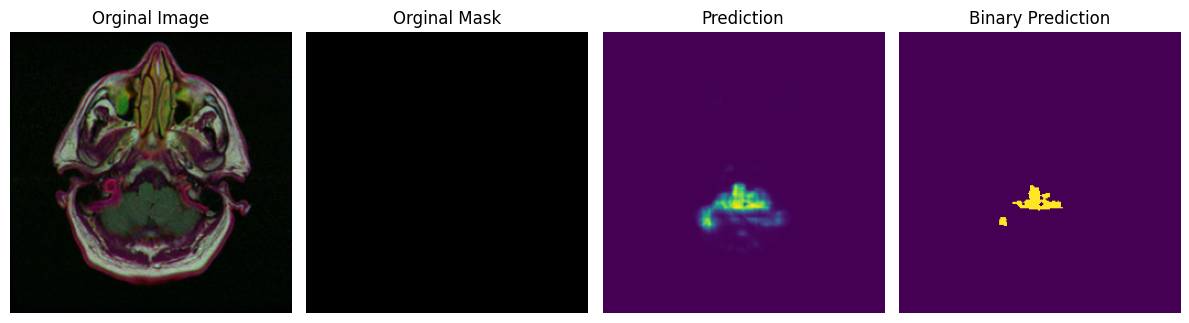

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


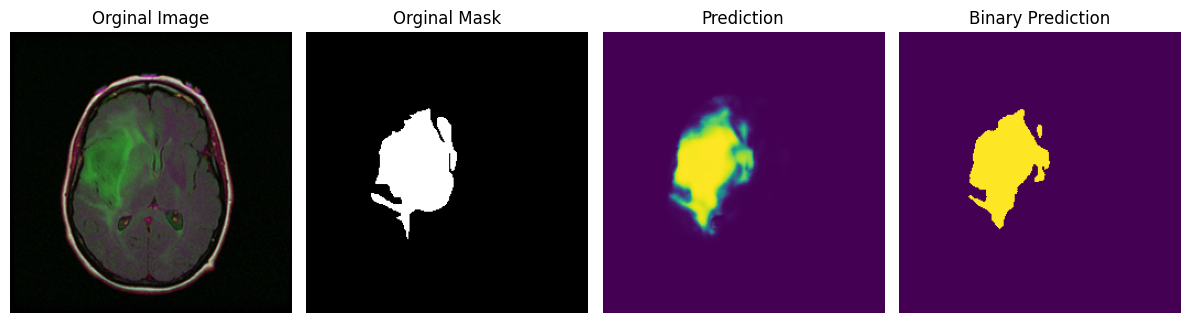

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


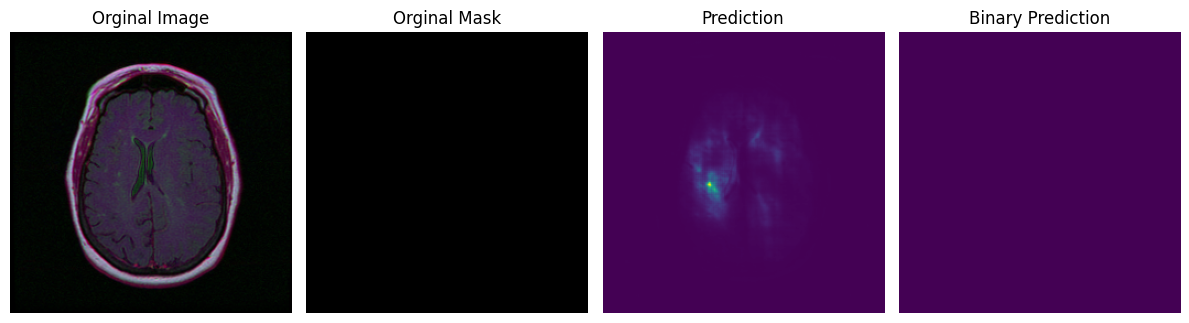

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


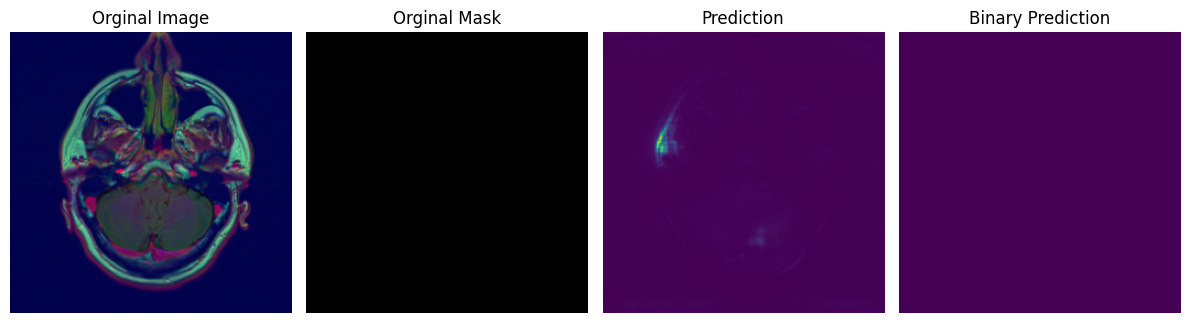

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


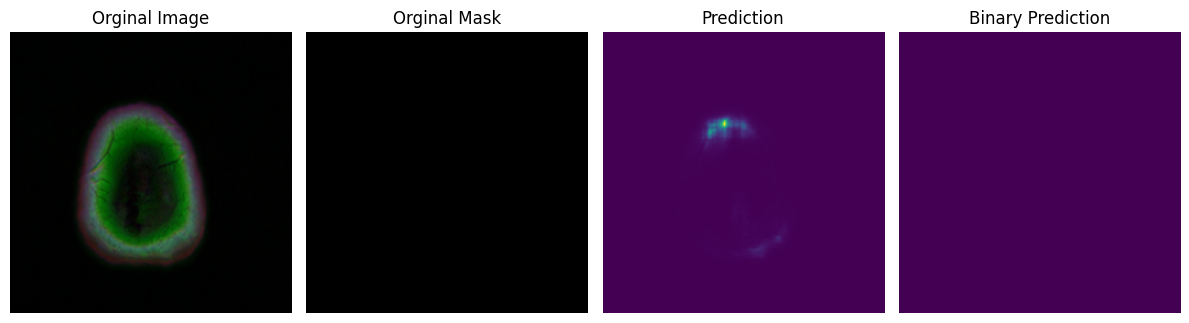

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


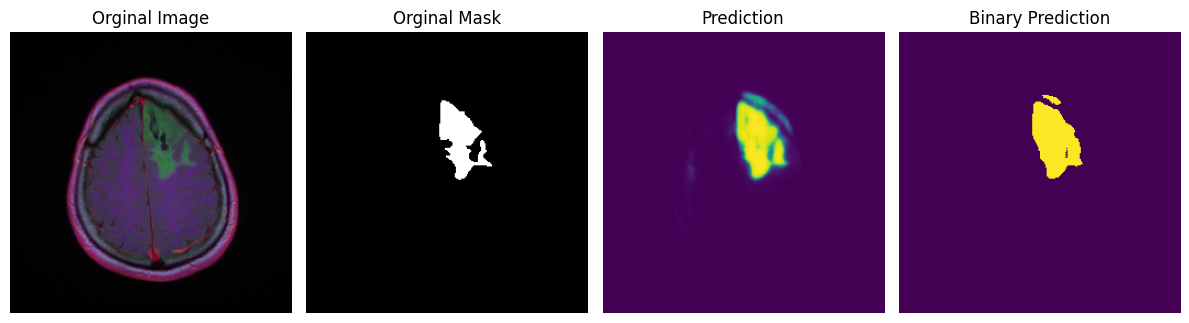

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


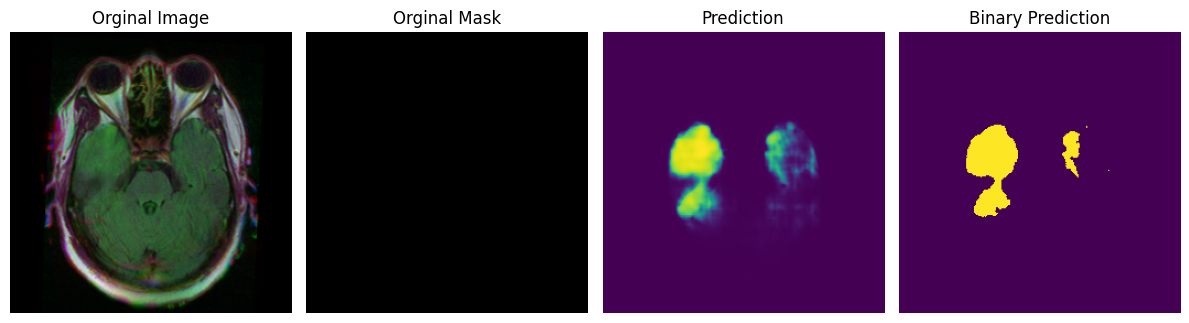

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


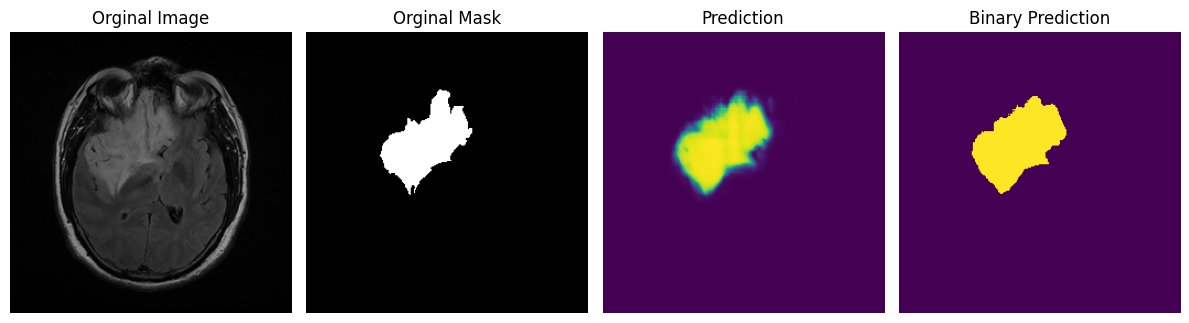

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


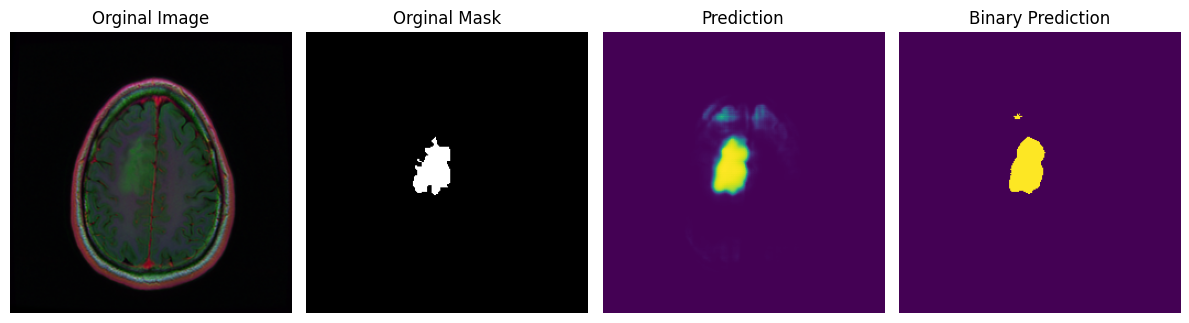

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


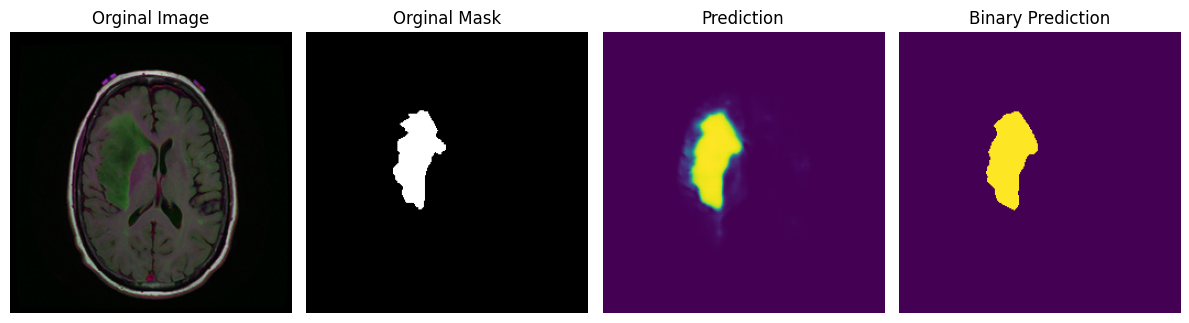

In [171]:
for i in range (10):
  idx = np.random.randint (0, len(imagePath_df))

  imagePath =imagePath_df['image-path'].iloc[idx]
  maskPath = imagePath_df['mask-path'].iloc[idx]

  image = cv2.imread(imagePath)
  mask = cv2.imread(maskPath)

  img = cv2.resize(image,(ImgHieght,ImgWidth))
  img = img / 255
  img = img[np.newaxis,: , :, :]
  pred = unet_model.predict(img)

  plt.figure (figsize=(12,12))

  plt.subplot(1,4,1)
  plt.imshow(np.squeeze(img))
  plt.title('Orginal Image')
  plt.axis('off')

  plt.subplot(1,4,2)
  plt.imshow(mask)
  plt.title('Orginal Mask')
  plt.axis('off')

  plt.subplot(1,4,3)
  plt.imshow(np.squeeze(pred))
  plt.title("Prediction")
  plt.axis('off')

  plt.subplot(1,4,4)
  plt.imshow(np.squeeze(pred)> 0.5)
  plt.title('Binary Prediction')
  plt.axis('off')

  plt.tight_layout()
  plt.show()